Plot Antarctic Tide Range
=========================

Demonstrates plotting the tidal amplitudes around Antarctica

OTIS format tidal solutions provided by Ohio State University and ESR  
- http://volkov.oce.orst.edu/tides/region.html  
- https://www.esr.org/research/polar-tide-models/list-of-polar-tide-models/
- ftp://ftp.esr.org/pub/datasets/tmd/  

Global Tide Model (GOT) solutions provided by Richard Ray at GSFC  

Finite Element Solution (FES) provided by AVISO  
- https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes.html
        
#### Python Dependencies
 - [numpy: Scientific Computing Tools For Python](https://www.numpy.org)  
 - [scipy: Scientific Tools for Python](https://www.scipy.org/)  
 - [pyproj: Python interface to PROJ library](https://pypi.org/project/pyproj/)  
 - [netCDF4: Python interface to the netCDF C library](https://unidata.github.io/netcdf4-python/)  
 - [matplotlib: Python 2D plotting library](http://matplotlib.org/)  
 - [cartopy: Python package designed for geospatial data processing](https://scitools.org.uk/cartopy/docs/latest/)  

#### Program Dependencies

- `convert_ll_xy.py`: convert lat/lon points to and from projected coordinates  
- `read_tide_model.py`: extract tidal harmonic constants from OTIS tide models  
- `read_netcdf_model.py`: extract tidal harmonic constants from netcdf models  
- `read_GOT_model.py`: extract tidal harmonic constants from GSFC GOT models  
- `read_FES_model.py`: extract tidal harmonic constants from FES tide models  

This notebook uses Jupyter widgets to set parameters for calculating the tidal maps.  
The widgets can be installed as described below.  
```
pip3 install --user ipywidgets
jupyter nbextension install --user --py widgetsnbextension
jupyter nbextension enable --user --py widgetsnbextension
jupyter-notebook
```

#### Load modules

In [1]:
import os
import pyproj
import datetime
import numpy as np
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2.0
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import ipywidgets as widgets
from IPython.display import HTML

from pyTMD.read_tide_model import extract_tidal_constants
from pyTMD.read_netcdf_model import extract_netcdf_constants
from pyTMD.read_GOT_model import extract_GOT_constants
from pyTMD.read_FES_model import extract_FES_constants
#-- autoreload
%load_ext autoreload
%autoreload 2

#### Set parameters  for program

- Model directory  
- Tide model  

In [2]:
#-- set the directory with tide models
dirText = widgets.Text(
    value=os.getcwd(),
    description='Directory:',
    disabled=False
)

#-- dropdown menu for setting tide model
model_list = ['CATS0201','CATS2008','TPXO9-atlas','TPXO9-atlas-v2',
    'TPXO9-atlas-v3','TPXO9-atlas-v4','TPXO9.1','TPXO8-atlas',
    'TPXO7.2','GOT4.7','GOT4.8','GOT4.10','FES2014']
modelDropdown = widgets.Dropdown(
    options=model_list,
    value='CATS2008',
    description='Model:',
    disabled=False,
)

#-- display widgets for setting directory, model
widgets.VBox([dirText,modelDropdown])

#### Setup tide model parameters

In [3]:
#-- directory with tide models
tide_dir = os.path.expanduser(dirText.value)
MODEL = modelDropdown.value
if (MODEL == 'CATS0201'):
    grid_file = os.path.join(tide_dir,'cats0201_tmd','grid_CATS')
    model_file = os.path.join(tide_dir,'cats0201_tmd','h0_CATS02_01')
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'CATS2008'):
    grid_file = os.path.join(tide_dir,'CATS2008','grid_CATS2008')
    model_file = os.path.join(tide_dir,'CATS2008','hf.CATS2008.out')
    model_format = 'OTIS'
    EPSG = 'CATS2008'
    TYPE = 'z'
elif (MODEL == 'TPXO9-atlas'):
    model_directory = os.path.join(tide_dir,'TPXO9_atlas')
    grid_file = os.path.join(model_directory,'grid_tpxo9_atlas.nc.gz')
    model_files = ['h_q1_tpxo9_atlas_30.nc.gz','h_o1_tpxo9_atlas_30.nc.gz',
        'h_p1_tpxo9_atlas_30.nc.gz','h_k1_tpxo9_atlas_30.nc.gz',
        'h_n2_tpxo9_atlas_30.nc.gz','h_m2_tpxo9_atlas_30.nc.gz',
        'h_s2_tpxo9_atlas_30.nc.gz','h_k2_tpxo9_atlas_30.nc.gz',
        'h_m4_tpxo9_atlas_30.nc.gz','h_ms4_tpxo9_atlas_30.nc.gz',
        'h_mn4_tpxo9_atlas_30.nc.gz','h_2n2_tpxo9_atlas_30.nc.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'netcdf'
    TYPE = 'z'
    SCALE = 1.0/1000.0
    GZIP = True
elif (MODEL == 'TPXO9-atlas-v2'):
    model_directory = os.path.join(tide_dir,'TPXO9_atlas_v2')
    grid_file = os.path.join(model_directory,'grid_tpxo9_atlas_30_v2.nc.gz')
    model_files = ['h_q1_tpxo9_atlas_30_v2.nc.gz','h_o1_tpxo9_atlas_30_v2.nc.gz',
        'h_p1_tpxo9_atlas_30_v2.nc.gz','h_k1_tpxo9_atlas_30_v2.nc.gz',
        'h_n2_tpxo9_atlas_30_v2.nc.gz','h_m2_tpxo9_atlas_30_v2.nc.gz',
        'h_s2_tpxo9_atlas_30_v2.nc.gz','h_k2_tpxo9_atlas_30_v2.nc.gz',
        'h_m4_tpxo9_atlas_30_v2.nc.gz','h_ms4_tpxo9_atlas_30_v2.nc.gz',
        'h_mn4_tpxo9_atlas_30_v2.nc.gz','h_2n2_tpxo9_atlas_30_v2.nc.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'netcdf'
    TYPE = 'z'
    SCALE = 1.0/1000.0
    GZIP = True
elif (MODEL == 'TPXO9-atlas-v3'):
    model_directory = os.path.join(tide_dir,'TPXO9_atlas_v3')
    grid_file = os.path.join(model_directory,'grid_tpxo9_atlas_30_v3.nc.gz')
    model_files = ['h_q1_tpxo9_atlas_30_v3.nc.gz','h_o1_tpxo9_atlas_30_v3.nc.gz',
        'h_p1_tpxo9_atlas_30_v3.nc.gz','h_k1_tpxo9_atlas_30_v3.nc.gz',
        'h_n2_tpxo9_atlas_30_v3.nc.gz','h_m2_tpxo9_atlas_30_v3.nc.gz',
        'h_s2_tpxo9_atlas_30_v3.nc.gz','h_k2_tpxo9_atlas_30_v3.nc.gz',
        'h_m4_tpxo9_atlas_30_v3.nc.gz','h_ms4_tpxo9_atlas_30_v3.nc.gz',
        'h_mn4_tpxo9_atlas_30_v3.nc.gz','h_2n2_tpxo9_atlas_30_v3.nc.gz',
        'h_mf_tpxo9_atlas_30_v3.nc.gz','h_mm_tpxo9_atlas_30_v3.nc.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'netcdf'
    TYPE = 'z'
    SCALE = 1.0/1000.0
    GZIP = True
elif (MODEL == 'TPXO9-atlas-v4'):
    model_directory = os.path.join(tide_dir,'TPXO9_atlas_v4')
    grid_file = os.path.join(model_directory,'grid_tpxo9_atlas_30_v4')
    model_files = ['h_q1_tpxo9_atlas_30_v4','h_o1_tpxo9_atlas_30_v4',
        'h_p1_tpxo9_atlas_30_v4','h_k1_tpxo9_atlas_30_v4',
        'h_n2_tpxo9_atlas_30_v4','h_m2_tpxo9_atlas_30_v4',
        'h_s2_tpxo9_atlas_30_v4','h_k2_tpxo9_atlas_30_v4',
        'h_m4_tpxo9_atlas_30_v4','h_ms4_tpxo9_atlas_30_v4',
        'h_mn4_tpxo9_atlas_30_v4','h_2n2_tpxo9_atlas_30_v4',
        'h_mf_tpxo9_atlas_30_v4','h_mm_tpxo9_atlas_30_v4']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'TPXO9.1'):
    grid_file = os.path.join(tide_dir,'TPXO9.1','DATA','grid_tpxo9')
    model_file = os.path.join(tide_dir,'TPXO9.1','DATA','h_tpxo9.v1')
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'TPXO8-atlas'):
    grid_file = os.path.join(tide_dir,'tpxo8_atlas','grid_tpxo8atlas_30_v1')
    model_file = os.path.join(tide_dir,'tpxo8_atlas','hf.tpxo8_atlas_30_v1')
    model_format = 'ATLAS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'TPXO7.2'):
    grid_file = os.path.join(tide_dir,'TPXO7.2_tmd','grid_tpxo7.2')
    model_file = os.path.join(tide_dir,'TPXO7.2_tmd','h_tpxo7.2')
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'GOT4.7'):
    model_directory = os.path.join(tide_dir,'GOT4.7','grids_oceantide')
    model_files = ['q1.d.gz','o1.d.gz','p1.d.gz','k1.d.gz','n2.d.gz',
        'm2.d.gz','s2.d.gz','k2.d.gz','s1.d.gz','m4.d.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'GOT'
    SCALE = 1.0/100.0
    GZIP = True
elif (MODEL == 'GOT4.8'):
    model_directory = os.path.join(tide_dir,'got4.8','grids_oceantide')
    model_files = ['q1.d.gz','o1.d.gz','p1.d.gz','k1.d.gz','n2.d.gz',
        'm2.d.gz','s2.d.gz','k2.d.gz','s1.d.gz','m4.d.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'GOT'
    SCALE = 1.0/100.0
    GZIP = True
elif (MODEL == 'GOT4.10'):
    model_directory = os.path.join(tide_dir,'GOT4.10c','grids_oceantide')
    model_files = ['q1.d.gz','o1.d.gz','p1.d.gz','k1.d.gz','n2.d.gz',
        'm2.d.gz','s2.d.gz','k2.d.gz','s1.d.gz','m4.d.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    model_format = 'GOT'
    SCALE = 1.0/100.0
    GZIP = True
elif (MODEL == 'FES2014'):
    model_directory = os.path.join(tide_dir,'fes2014','ocean_tide')
    model_files = ['2n2.nc.gz','eps2.nc.gz','j1.nc.gz','k1.nc.gz',
        'k2.nc.gz','l2.nc.gz','la2.nc.gz','m2.nc.gz','m3.nc.gz','m4.nc.gz',
        'm6.nc.gz','m8.nc.gz','mf.nc.gz','mks2.nc.gz','mm.nc.gz',
        'mn4.nc.gz','ms4.nc.gz','msf.nc.gz','msqm.nc.gz','mtm.nc.gz',
        'mu2.nc.gz','n2.nc.gz','n4.nc.gz','nu2.nc.gz','o1.nc.gz','p1.nc.gz',
        'q1.nc.gz','r2.nc.gz','s1.nc.gz','s2.nc.gz','s4.nc.gz','sa.nc.gz',
        'ssa.nc.gz','t2.nc.gz']
    model_file = [os.path.join(model_directory,m) for m in model_files]
    c = ['2n2','eps2','j1','k1','k2','l2','lambda2','m2','m3','m4','m6',
        'm8','mf','mks2','mm','mn4','ms4','msf','msqm','mtm','mu2','n2',
        'n4','nu2','o1','p1','q1','r2','s1','s2','s4','sa','ssa','t2']
    model_format = 'FES'
    TYPE = 'z'
    SCALE = 1.0/100.0
    GZIP = True

#### Setup coordinates for calculating tides

In [4]:
#-- create an image around Antarctica
xlimits = [-560.*5e3,560.*5e3]
ylimits = [-560.*5e3,560.*5e3]
spacing = [5e3,-5e3]
#-- x and y coordinates
x = np.arange(xlimits[0],xlimits[1]+spacing[0],spacing[0])
y = np.arange(ylimits[1],ylimits[0]+spacing[1],spacing[1])
xgrid,ygrid = np.meshgrid(x,y)
#-- x and y dimensions
nx = int((xlimits[1]-xlimits[0])/spacing[0])+1
ny = int((ylimits[0]-ylimits[1])/spacing[1])+1
#-- convert image coordinates from polar stereographic to latitude/longitude
crs1 = pyproj.CRS.from_string("epsg:{0:d}".format(3031))
crs2 = pyproj.CRS.from_string("epsg:{0:d}".format(4326))
transformer = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True)
lon,lat = transformer.transform(xgrid.flatten(), ygrid.flatten())

#### Infer minor amplitudes from the major constituents

In [5]:
def infer_minor_amplitudes(zmajor,constituents):
    #-- number of constituents
    npts,nc = np.shape(zmajor)    
    cindex = ['q1','o1','p1','k1','n2','m2','s2','k2']
    #-- re-order zmajor to correspond to cindex
    z8 = np.ma.zeros((npts,8))
    ni = 0
    for i,c in enumerate(cindex):
        j = [j for j,val in enumerate(constituents) if val == c]
        if j:
            j1, = j
            z8[:,i] = zmajor[:,j1]
            ni += 1
    #-- list of minor constituents
    minor = ['2q1','sigma1','rho1','m1','m1','chi1','pi1','phi1','theta1',
        'j1','oo1','2n2','mu2','nu2','lambda2','l2','l2','t2']
    #-- only add minor constituents that are not on the list of major values
    minor_flag = [m not in constituents for m in minor]
    #-- estimate minor constituents
    zmin = np.zeros((npts,18))
    zmin[:,0] = 0.263*z8[:,0] - 0.0252*z8[:,1]#-- 2Q1
    zmin[:,1] = 0.297*z8[:,0] - 0.0264*z8[:,1]#-- sigma1
    zmin[:,2] = 0.164*z8[:,0] + 0.0048*z8[:,1]#-- rho1
    zmin[:,3] = 0.0140*z8[:,1] + 0.0101*z8[:,3]#-- M1
    zmin[:,4] = 0.0389*z8[:,1] + 0.0282*z8[:,3]#-- M1
    zmin[:,5] = 0.0064*z8[:,1] + 0.0060*z8[:,3]#-- chi1
    zmin[:,6] = 0.0030*z8[:,1] + 0.0171*z8[:,3]#-- pi1
    zmin[:,7] = -0.0015*z8[:,1] + 0.0152*z8[:,3]#-- phi1
    zmin[:,8] = -0.0065*z8[:,1] + 0.0155*z8[:,3]#-- theta1
    zmin[:,9] = -0.0389*z8[:,1] + 0.0836*z8[:,3]#-- J1
    zmin[:,10] = -0.0431*z8[:,1] + 0.0613*z8[:,3]#-- OO1
    zmin[:,11] = 0.264*z8[:,4] - 0.0253*z8[:,5]#-- 2N2
    zmin[:,12] = 0.298*z8[:,4] - 0.0264*z8[:,5]#-- mu2
    zmin[:,13] = 0.165*z8[:,4] + 0.00487*z8[:,5]#-- nu2
    zmin[:,14] = 0.0040*z8[:,5] + 0.0074*z8[:,6]#-- lambda2
    zmin[:,15] = 0.0131*z8[:,5] + 0.0326*z8[:,6]#-- L2
    zmin[:,16] = 0.0033*z8[:,5] + 0.0082*z8[:,6]#-- L2
    zmin[:,17] = 0.0585*z8[:,6]#-- t2
    #-- only add minor constituents that are not major
    return np.where(minor_flag, np.abs(zmin), 0.0)

#### Calculate tide map

In [6]:
#-- read tidal constants and interpolate to grid points
if model_format in ('OTIS','ATLAS'):
    amp,ph,D,c = extract_tidal_constants(lon, lat, grid_file, model_file,
        EPSG, TYPE=TYPE, METHOD='spline', GRID=model_format)
elif (model_format == 'netcdf'):
    amp,ph,D,c = extract_netcdf_constants(lon, lat, grid_file, model_file,
        TYPE=TYPE, METHOD='spline', SCALE=SCALE, GZIP=GZIP)
elif (model_format == 'GOT'):
    amp,ph,c = extract_GOT_constants(lon, lat, model_file,
        METHOD='spline', SCALE=SCALE, GZIP=GZIP)
elif (model_format == 'FES'):
    amp,ph = extract_FES_constants(lon, lat, model_file, TYPE=TYPE,
        VERSION=MODEL, METHOD='spline', SCALE=SCALE, GZIP=GZIP)
    
#-- calculate minor constituent amplitudes
minor_amp = infer_minor_amplitudes(amp,c)
#-- calculate sum of major and minor amplitudes
tide_range = np.sum(amp,axis=1) + np.sum(minor_amp,axis=1)
#-- convert from meters to centimeters
tide_cm = 100.0*np.reshape(tide_range,(ny,nx))

#### Create plot of tidal range

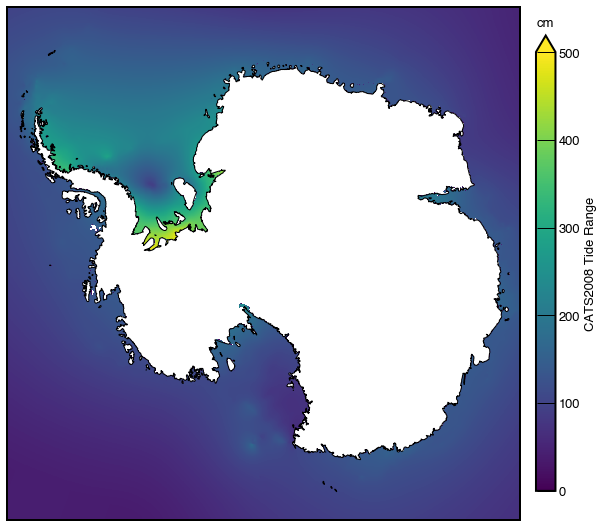

In [7]:
#-- plot Antarctic tide range
projection = ccrs.Stereographic(central_longitude=0.0,
    central_latitude=-90,true_scale_latitude=-71.0)
fig, ax = plt.subplots(num=1, figsize=(9,8),
    subplot_kw=dict(projection=projection))
#-- plot tide height
vmin,vmax = (0, np.max(tide_cm))
extent = (xlimits[0],xlimits[1],ylimits[0],ylimits[1])
im = ax.imshow(tide_cm, interpolation='nearest',
    vmin=vmin, vmax=vmax, transform=projection,
    extent=extent, origin='upper')
#-- add high resolution cartopy coastlines
ax.coastlines('10m')

#-- Add colorbar and adjust size
#-- pad = distance from main plot axis
#-- extend = add extension triangles to upper and lower bounds
#-- options: neither, both, min, max
#-- shrink = percent size of colorbar
#-- aspect = lengthXwidth aspect of colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.025, extend='max',
    extendfrac=0.0375, shrink=0.85, aspect=22.5, drawedges=False)
#-- rasterized colorbar to remove lines
cbar.solids.set_rasterized(True)
#-- Add label to the colorbar
cbar.ax.set_ylabel('{0} Tide Range'.format(MODEL), fontsize=13)
cbar.ax.set_xlabel('cm', fontsize=13)
cbar.ax.xaxis.set_label_coords(0.50, 1.04)
#-- ticks lines all the way across
cbar.ax.tick_params(which='both', width=1, length=18,
    labelsize=13, direction='in')

#-- set x and y limits
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)

#-- stronger linewidth on frame
ax.spines['geo'].set_linewidth(2.0)
ax.spines['geo'].set_capstyle('projecting')
#-- adjust subplot within figure
fig.subplots_adjust(left=0.02,right=0.98,bottom=0.05,top=0.98)
#-- show the plot
plt.show()